Training started...
Iteration 50/200, Total Loss: 2.006391, PDE Loss: 0.684382, Boundary Loss: 1.322009
Iteration 100/200, Total Loss: 2.000531, PDE Loss: 0.710232, Boundary Loss: 1.290299
Iteration 150/200, Total Loss: 2.000495, PDE Loss: 0.709100, Boundary Loss: 1.291395
Iteration 200/200, Total Loss: 2.000494, PDE Loss: 0.709232, Boundary Loss: 1.291263
Training finished.


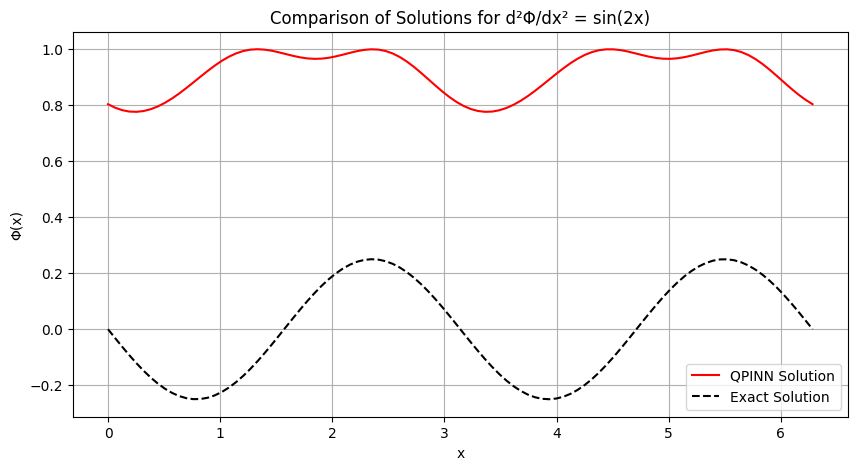

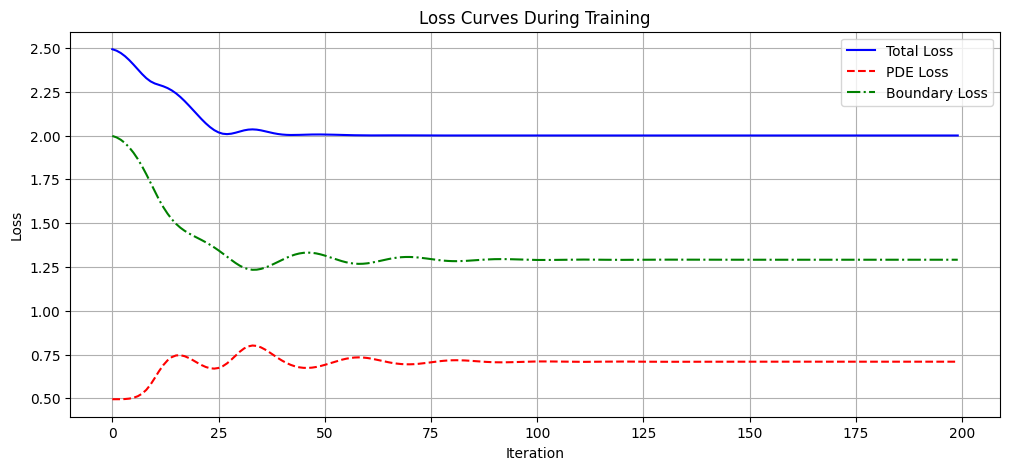

In [38]:
import torch
import torch.nn as nn
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------------------------
# Hyperparameter Settings
# ----------------------------------------------------------
num_qubits = 1                # Number of qubits used in the quantum circuit
num_layers = 3                # Number of trainable layers (variational layers)
learning_rate = 0.01          # Learning rate for the optimizer
num_iterations = 200          # Number of training iterations
n_points = 100                # Number of training points sampled in the interval [0, 2π]

# ----------------------------------------------------------
# Create the PennyLane device (default qubit simulator)
# ----------------------------------------------------------
dev = qml.device("default.qubit", wires=num_qubits)

# ----------------------------------------------------------
# Define the quantum circuit
# ----------------------------------------------------------
@qml.qnode(dev, interface="torch", diff_method="backprop")
def quantum_model(x, weights, entanglement_weights):
    for i in range(num_qubits):
        qml.Rot(weights[0, i, 0], weights[0, i, 1], weights[0, i, 2], wires=i)

    # qml.CRX(entanglement_weights[0], wires=[0, 1])
    # qml.CRX(entanglement_weights[1], wires=[1, 2])
    
    for l in range(num_layers):
        for i in range(num_qubits):
            qml.RZ(2 * x, wires=i)
    
        # qml.CRX(entanglement_weights[2], wires=[0, 1])
        # qml.CRX(entanglement_weights[3], wires=[1, 2])
    
        for i in range(num_qubits):
            qml.Rot(weights[1, i, 0], weights[1, i, 1], weights[1, i, 2], wires=i)

    expectation_sum = 0
    for i in range(num_qubits):
        expectation_sum += qml.PauliZ(i)
    obs = expectation_sum / num_qubits
    return qml.expval(obs)

# ----------------------------------------------------------
# Define the QPINN network structure, encapsulating the QNode
# ----------------------------------------------------------
class QPINN(nn.Module):
    def __init__(self):
        super(QPINN, self).__init__()
        # Initialize trainable parameters
        # Note: Multiply by a small factor to keep the initial parameters small, which helps with convergence
        self.weights = nn.Parameter(0.01 * torch.randn(2, 3, 3, dtype=torch.float32))
        self.entanglement_weights = nn.Parameter(0.01 * torch.randn(4, dtype=torch.float32))

    def forward(self, x):
        # Assume x is a one-dimensional tensor; call the QNode for each sample
        outputs = []
        for xi in x:
            outputs.append(quantum_model(xi, self.weights, self.entanglement_weights))
        return torch.stack(outputs)

# ----------------------------------------------------------
# Create an instance of the QPINN model
# ----------------------------------------------------------
model = QPINN()

# ----------------------------------------------------------
# Construct the physics-informed loss function (PDE residual and boundary conditions)
# ----------------------------------------------------------
def compute_pde_residual(phi_pred, x):
    """
    Compute the PDE residual:
        d²Φ/dx² - sin(2x) = 0
    Use PyTorch’s automatic differentiation to compute the first and second derivatives.
    """
    # Compute the first derivative dΦ/dx
    dphi_dx = torch.autograd.grad(
        phi_pred, x,
        grad_outputs=torch.ones_like(phi_pred),
        create_graph=True
    )[0]
    # Compute the second derivative d²Φ/dx²
    d2phi_dx2 = torch.autograd.grad(
        dphi_dx, x,
        grad_outputs=torch.ones_like(dphi_dx),
        create_graph=True
    )[0]

    # Define the PDE residual as d²Φ/dx² - sin(2x)
    residual = d2phi_dx2 - torch.sin(2 * x)
    return residual

def loss_function(x):
    """
    Compute the total loss:
      - PDE loss: Mean squared error of the residual
      - Boundary condition loss: Apply a penalty to ensure Φ(0)=0 and Φ(2π)=0
    """
    x.requires_grad_(True)
    phi_pred = model(x)
    residual = compute_pde_residual(phi_pred, x)
    pde_loss = torch.mean(residual**2)

    # Boundary conditions: Φ(0) = 0 and Φ(2π) = 0
    bc0 = model(torch.tensor([0.0], dtype=x.dtype))
    bc1 = model(torch.tensor([2 * np.pi], dtype=x.dtype))
    bc_loss = bc0.pow(2).mean() + bc1.pow(2).mean()

    total_loss = pde_loss + bc_loss  # Adjust the weight for boundary condition loss as needed
    return total_loss, pde_loss, bc_loss

# ----------------------------------------------------------
# Model training
# ----------------------------------------------------------
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
x_train = torch.linspace(0, 2 * np.pi, n_points, dtype=torch.float32)

total_loss_list = []
pde_loss_list = []
bc_loss_list = []

print("Training started...")
for i in range(num_iterations):
    optimizer.zero_grad()
    total_loss_value, pde_loss_value, bc_loss_value = loss_function(x_train)
    total_loss_value.backward()
    optimizer.step()

    total_loss_list.append(total_loss_value.item())
    pde_loss_list.append(pde_loss_value.item())
    bc_loss_list.append(bc_loss_value.item())

    if (i + 1) % 50 == 0:
        print(f"Iteration {i+1}/{num_iterations}, Total Loss: {total_loss_value.item():.6f}, "
              f"PDE Loss: {pde_loss_value.item():.6f}, Boundary Loss: {bc_loss_value.item():.6f}")

print("Training finished.")

# ----------------------------------------------------------
# Model evaluation and comparison of solutions
# ----------------------------------------------------------
# Generate grid data for evaluation
x_eval = torch.linspace(0, 2 * np.pi, 100, dtype=torch.float32)
with torch.no_grad():
    phi_pred_eval = model(x_eval)

def exact_solution(x):
    """
    Exact solution:
      Φ(x) = -1/4 * sin(2x)
    """
    return -0.25 * torch.sin(2 * x)

phi_exact_eval = exact_solution(x_eval)

# ----------------------------------------------------------
# Plot the comparison between QPINN solution and the exact solution
# ----------------------------------------------------------
plt.figure(figsize=(10, 5))
plt.plot(x_eval.cpu().numpy(), phi_pred_eval.cpu().numpy(), 'r-', label='QPINN Solution')
plt.plot(x_eval.cpu().numpy(), phi_exact_eval.cpu().numpy(), 'k--', label='Exact Solution')
plt.title("Comparison of Solutions for d²Φ/dx² = sin(2x)")
plt.xlabel("x")
plt.ylabel("Φ(x)")
plt.legend()
plt.grid(True)
plt.show()

# ----------------------------------------------------------
# Plot the loss curves during training
# ----------------------------------------------------------
plt.figure(figsize=(12, 5))
plt.plot(total_loss_list, 'b-', label='Total Loss')
plt.plot(pde_loss_list, 'r--', label='PDE Loss')
plt.plot(bc_loss_list, 'g-.', label='Boundary Loss')
plt.title("Loss Curves During Training")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


Training started...
Iteration 50/200, Total Loss: 0.004679, PDE Loss: 0.003756, Boundary Loss: 0.000923
Iteration 100/200, Total Loss: 0.002204, PDE Loss: 0.002070, Boundary Loss: 0.000134
Iteration 150/200, Total Loss: 0.001430, PDE Loss: 0.001425, Boundary Loss: 0.000004
Iteration 200/200, Total Loss: 0.001136, PDE Loss: 0.001134, Boundary Loss: 0.000002
Training finished.


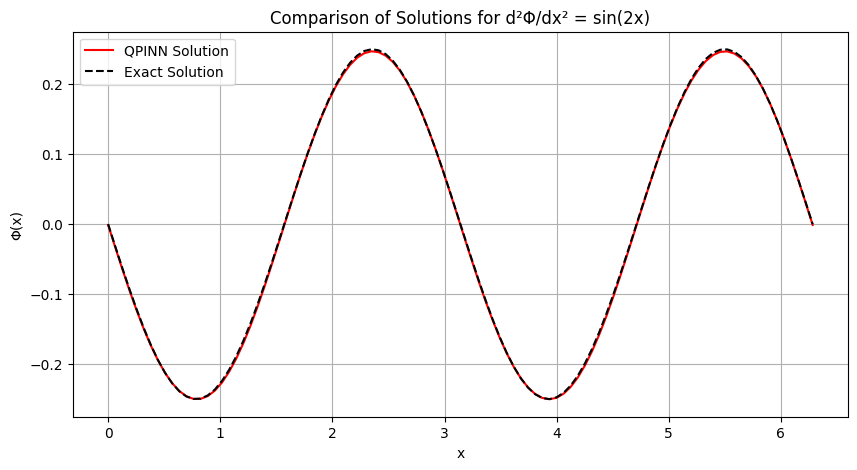

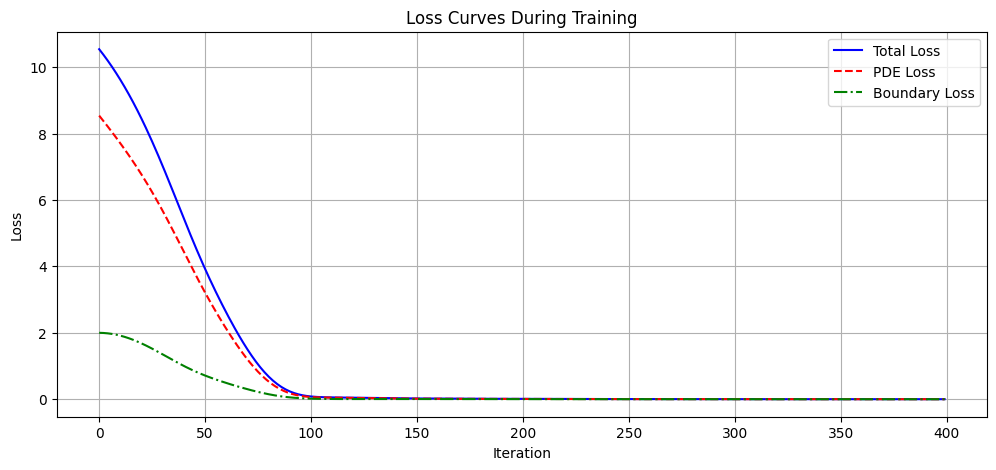

In [29]:
print("Training started...")
for i in range(num_iterations):
    optimizer.zero_grad()
    total_loss_value, pde_loss_value, bc_loss_value = loss_function(x_train)
    total_loss_value.backward()
    optimizer.step()

    total_loss_list.append(total_loss_value.item())
    pde_loss_list.append(pde_loss_value.item())
    bc_loss_list.append(bc_loss_value.item())

    if (i + 1) % 50 == 0:
        print(f"Iteration {i+1}/{num_iterations}, Total Loss: {total_loss_value.item():.6f}, "
              f"PDE Loss: {pde_loss_value.item():.6f}, Boundary Loss: {bc_loss_value.item():.6f}")

print("Training finished.")

# ----------------------------------------------------------
# Model evaluation and comparison of solutions
# ----------------------------------------------------------
# Generate grid data for evaluation
x_eval = torch.linspace(0, 2 * np.pi, 100, dtype=torch.float32)
with torch.no_grad():
    phi_pred_eval = model(x_eval)

def exact_solution(x):
    """
    Exact solution:
      Φ(x) = -1/4 * sin(2x)
    """
    return -0.25 * torch.sin(2 * x)

phi_exact_eval = exact_solution(x_eval)

# ----------------------------------------------------------
# Plot the comparison between QPINN solution and the exact solution
# ----------------------------------------------------------
plt.figure(figsize=(10, 5))
plt.plot(x_eval.cpu().numpy(), phi_pred_eval.cpu().numpy(), 'r-', label='QPINN Solution')
plt.plot(x_eval.cpu().numpy(), phi_exact_eval.cpu().numpy(), 'k--', label='Exact Solution')
plt.title("Comparison of Solutions for d²Φ/dx² = sin(2x)")
plt.xlabel("x")
plt.ylabel("Φ(x)")
plt.legend()
plt.grid(True)
plt.show()

# ----------------------------------------------------------
# Plot the loss curves during training
# ----------------------------------------------------------
plt.figure(figsize=(12, 5))
plt.plot(total_loss_list, 'b-', label='Total Loss')
plt.plot(pde_loss_list, 'r--', label='PDE Loss')
plt.plot(bc_loss_list, 'g-.', label='Boundary Loss')
plt.title("Loss Curves During Training")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()